# 文本编码与Tokenizer

## 一，BPE算法

将常见字节组合打包成数字（Token),实现对文本地压缩

**BPE**:Tokenizer的一种主流实现方式，自动寻找最值得合并的字节组合  
核心思想：从上往下不断合并  
1）把训练语料里所有的字母（或字节）拆出来，作为最初的词表  
2）看词表里面哪两个相邻的字符一起出现的次数最多  
3）将这个组合合成一个新的字符，加入词表  
4）重复2，3步骤，直到达到设定目标  


### 优点
1.灵活：生僻词也可以拆成模型认识的小零件  
2.高效：通过语料库的统计，将最常用的短语或词根变成Token  
3.主流大模型通用  


### 实现一个BPE训练器　　
**邻近计数**：遍历语料，找出相邻的两个Token对   

**合并**：找到Token后，将语料库里面所有的（A，B）替换成（AB）  


In [6]:
import collections #collection的作用：创建一个计数器对象，用来统计某个集合（列表、元组、字符串）中元素出现的次数

#初始化语料，每个词语末尾加结束符
#:后面的数字为你的词表中的词出现的频率
word_freqs={
  'l o w </w>':5,
  'l o w e r </w>':2,
  'n e w e s t </w>':6,
  'w i d e s t </w>':3,
}
print("初始语料：",word_freqs )

初始语料： {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w e s t </w>': 6, 'w i d e s t </w>': 3}


In [7]:
def get_stats(word_freqs):
    """统计语料中相邻字符对出现的频率"""#滑动窗口抓取：遍历symbols，观察相邻
    pairs = collections.defaultdict(int)
    for word, freq in word_freqs.items():
        symbols = word.split()#拆分单词
        for i in range(len(symbols)-1):#相邻两个Token组成一个元组作为Key，累加出现频次
            pairs[symbols[i], symbols[i+1]] += freq
    return pairs


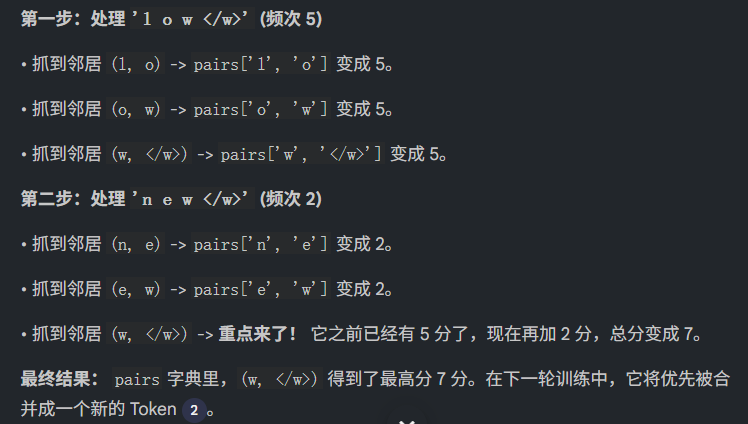

In [8]:
def merge_vocab(pair,v_in):
    """合并语料中出现频率最高的字符对"""
    v_out = {}#创建输出的词典
    bigram = ' '.join(pair)#创建字符对的字符串形式
    replacement = ''.join(pair)
    for word in v_in:#替换e s 为es
        w_out = word.replace(bigram, replacement)
        v_out[w_out] = v_in[word]
    return v_out

迭代开始
第1轮：合并e+s，频率为9
第2轮：合并es+t，频率为9
第3轮：合并est+</w>，频率为9
第4轮：合并l+o，频率为7
第5轮：合并lo+w，频率为7
第6轮：合并n+e，频率为6
第7轮：合并ne+w，频率为6
第8轮：合并new+est</w>，频率为6
第9轮：合并low+</w>，频率为5
第10轮：合并w+i，频率为3


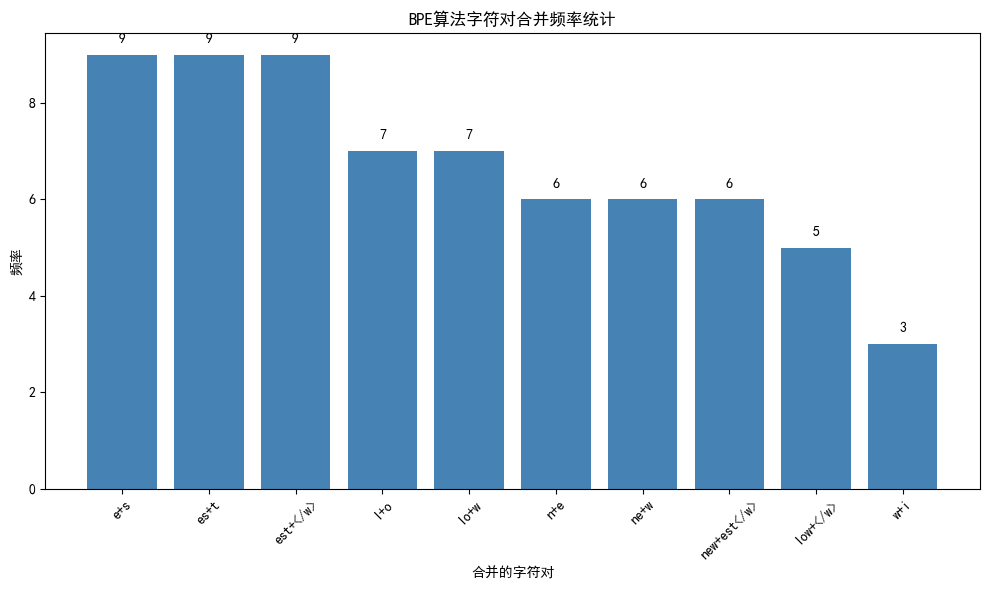

最终语料： {'low</w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'wi d est</w>': 3}


In [10]:
history_pairs=[]
history_freqs=[]
num_merges=10
current_word_freq=word_freqs.copy()

print('迭代开始')
for i in range(num_merges):
    pairs = get_stats(current_word_freq)
    if not pairs:#没有字符可合并时退出
        break
    best_pair = max(pairs, key=pairs.get)#频率最高
    freq = pairs[best_pair]

    pair_str = f"{best_pair[0]}+{best_pair[1]}"
    history_pairs.append(pair_str)
    history_freqs.append(freq)

    #合并
    current_word_freq = merge_vocab(best_pair, current_word_freq)
    print(f'第{i+1}轮：合并{pair_str}，频率为{freq}')

#绘图
import matplotlib.pyplot as plt
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  
# plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # 适配Mac
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.figure(figsize=(10,6))
plt.bar(history_pairs, history_freqs,color='steelblue')
plt.xlabel('合并的字符对')
plt.ylabel('频率')
plt.title('BPE算法字符对合并频率统计')
plt.xticks(rotation=45)
for i,v in enumerate(history_freqs):
    plt.text(i, v + 0.2, str(v), ha='center', va='bottom')
plt.tight_layout()
plt.show()

print('最终语料：',current_word_freq )

### BPE性能优化  
#### 倒排索引 :  
如果用原始方法，需要对大型语料库从头到尾进行遍历，好比为了一个错别字把整本书抄一遍  
倒排索引可以实现局部更新，只去修改受影响的地方

普通：每合并一个对，就遍历整个词典（包含几万个唯一词）去替换  
优化设计：  
1）建立索引：indices[(b'l' ,b'o')]={词1，词2}  

2）当确定合并[(b'l' ,b'o')]时，只修改词1和词2  

3）同时更新受影响的邻居（词1中原有的邻居关系会变，需要增量价键stats计数）

In [14]:
import collections #collection的作用：创建一个计数器对象，用来统计某个集合（列表、元组、字符串）中元素出现的次数

#初始化语料，每个词语末尾加结束符
corpus = {
    0: ['l', 'o', 'w', '</w>'],
    1: ['l', 'o', 'w', 'e', 'r', '</w>'],
    2: ['n', 'e', 'w', 'e', 's', 't', '</w>'],
    3: ['w', 'i', 'd', 'e', 's', 't', '</w>']
}
word_counts = {0: 5, 1: 2, 2: 6, 3: 3}
print("初始语料：",corpus )

初始语料： {0: ['l', 'o', 'w', '</w>'], 1: ['l', 'o', 'w', 'e', 'r', '</w>'], 2: ['n', 'e', 'w', 'e', 's', 't', '</w>'], 3: ['w', 'i', 'd', 'e', 's', 't', '</w>']}


In [15]:
#初始化倒排索引
# pair -> (word： cout_in_this_word)
pair_index=collections.defaultdict(lambda:collections.defaultdict(int))

def initialiize_index():
  for wid, tokens in corpus.items():
    for i in range(len(tokens)-1):
      pair=(tokens[i],tokens[i+1])
      pair_index[pair][wid]+=1
initialiize_index()
print("初始倒排索引：",dict(pair_index))

初始倒排索引： {('l', 'o'): defaultdict(<class 'int'>, {0: 1, 1: 1}), ('o', 'w'): defaultdict(<class 'int'>, {0: 1, 1: 1}), ('w', '</w>'): defaultdict(<class 'int'>, {0: 1}), ('w', 'e'): defaultdict(<class 'int'>, {1: 1, 2: 1}), ('e', 'r'): defaultdict(<class 'int'>, {1: 1}), ('r', '</w>'): defaultdict(<class 'int'>, {1: 1}), ('n', 'e'): defaultdict(<class 'int'>, {2: 1}), ('e', 'w'): defaultdict(<class 'int'>, {2: 1}), ('e', 's'): defaultdict(<class 'int'>, {2: 1, 3: 1}), ('s', 't'): defaultdict(<class 'int'>, {2: 1, 3: 1}), ('t', '</w>'): defaultdict(<class 'int'>, {2: 1, 3: 1}), ('w', 'i'): defaultdict(<class 'int'>, {3: 1}), ('i', 'd'): defaultdict(<class 'int'>, {3: 1}), ('d', 'e'): defaultdict(<class 'int'>, {3: 1})}


In [16]:
def get_best_pair():
    scores = collections.defaultdict(int)
    for pair, wids in pair_index.items():
        for wid, count in wids.items():
            scores[pair] += count * word_counts[wid]
    return max(scores, key=scores.get) if scores else None

In [ ]:

def update_word_and_index(best_pair):
    new_token = "".join(best_pair)
    affected_wids = list(pair_index[best_pair].keys())
    
    for wid in affected_wids:
        # a. 取出旧词
        old_tokens = corpus[wid]
        # b. 执行合并逻辑，生成 new_tokens
        # c. 【关键】识别哪些旧 pair 消失了，哪些新 pair 出现了
        # d. pair_index[old_pair].pop(wid)
        # e. pair_index[new_pair][wid] += 1
        pass 

# 执行演示
best = get_best_pair()
print(f"当前最高频词元对：{best}")

当前最高频词元对：('e', 's')


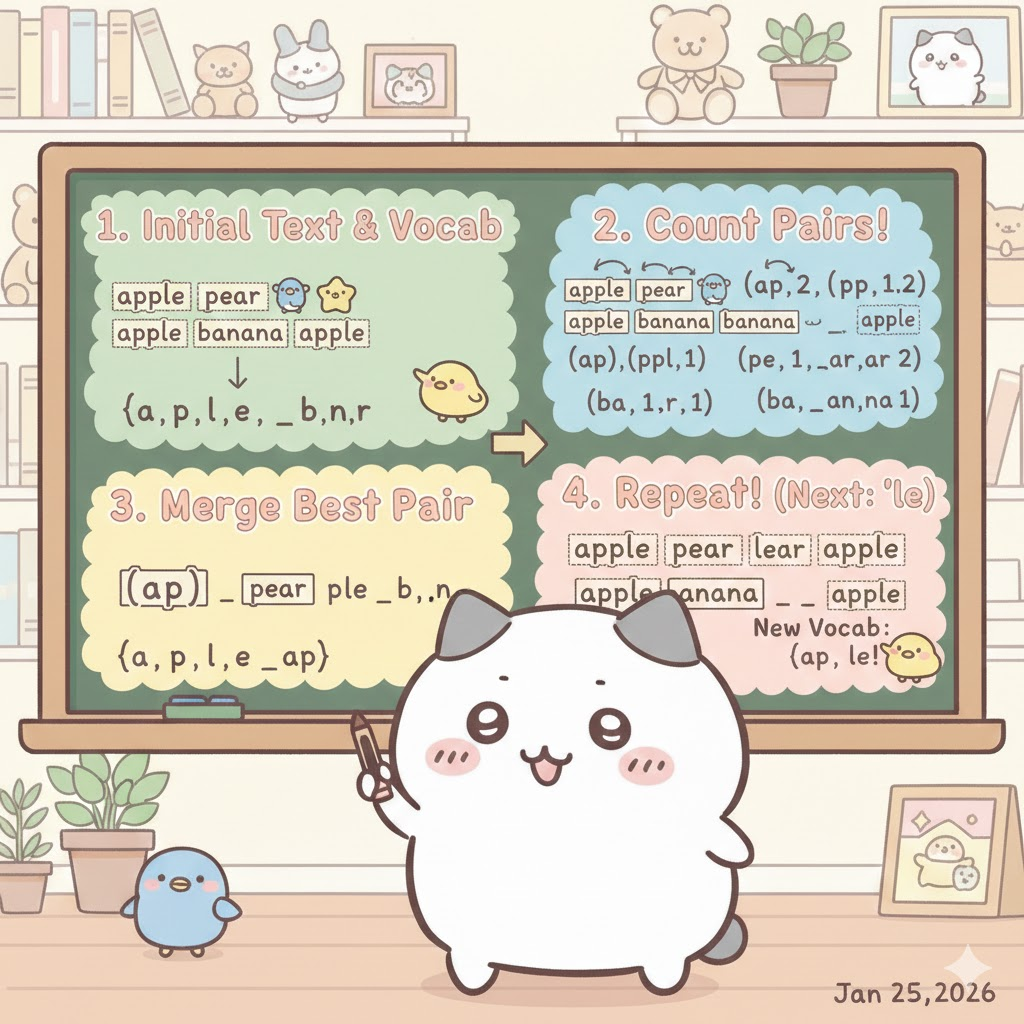

### Special Tokens

特殊Token是分词器中具有特定功能，不可拆分的单位。通常需要开发者手动预设，用于定义序列结构或触发特定行为

#### 结构化标记：界定序列边界
<|endoftext|> (EOS):告诉模型这篇文档已经结束  

目标：预训练时通常会将多篇短文拼接在一起。若没有EOS隔离，模型会认为前一篇末尾与后一篇开头存在因果关系　　 

|startoftext| (SOS):告诉模型这是新的文档  

目标：预训练时通常会将多篇短文拼接在一起。若没有SOS隔离，模型会认为前篇开头与后篇开头存在因果关系　  
　
[PAD]:填充,对齐时用于填充不等长的序列，配合掩码告知模型忽略   


#### 对话模板
特殊token在对话模型中用于标识system、user、assistant等不同角色的发言内容

#### 特定领域：提速与压缩  
法律、医学等专业领域可以将高频术语设置Special Tokens  


## 二，Tokenizer类的封装

### 1.Encode 
#### 核心原则：按照训练时的合并顺序  
训练阶段，每一对合并规则产生的顺序被记录下来  
Rank0：最早被合并  
RankN：最后被合并  

执行流程：  
1）预分词：先用正则或工具（BERT预分词器）把长句子切成初级单词，防止把不同单词的字母强行合并  
2）字节转换：将字符转换为UTF-8编码的字节流  
3）应用合并规则：按照训练时确定的合并顺序，依次把相邻的次元焊接  
4）映射ID:最后把得到的词元换成词表里对应的索引数字

####  编码流程  
输入单词： target  
初始字节序列：['t', 'a', 'r', 'g', 'e', 't']
Mergerule:  
1) e+t -> et Rank 0  
2) a+r -> ar Rank 1
3) g+et -> get Rank 2
4) t+et -> tet Rank 3

#### Round1:全局扫描  
当前序列：['t','a','r','g','e','t']  
存在相邻对：  
1) t,a (无规则)  
2) a,r Rank1  
3) r,g 无规则  
4) g,e 无规则  
5) e,t Rank0  
决策：  
虽然a,r在e,t前面出现，但是Rank0<Rank1 
优先合并Rank最小的  
执行合并：e+t=et

#### Round2: 新序列扫描  
当前序列 ['t','a','r','g','et']
存在的相邻对：  
1) t,a (无规则)  
2) a,r Rank1  
3) r,g 无规则  
4) g,et Rank2新规则  
决策：  
比较候选：a,r Rank1 vs g,et Rank2
Rank 1> rank 2   
执行合并：a+r->ar  


#### Round 3 继续迭代  
当前序列 ['t','ar','g','et']  
存在相邻对：  
1）t,ar(命中Rank3)
2）ar,g(无规则)  
3）g,et(命中Rank2)  
决策：  
比较候选者：t,ar(Rank3) vs g,et(Rank2)  
Rank2 < Rank3  
执行合并：g+et = get  


#### Round 4 结束  
当前序列： ['t','ar','get']  
存在相邻对：  
1）t,ar（命中Rank3）
2）ar,get（无规则）  
决策：  
只剩一个候选者，直接合并  
执行合并 t+ar = tar
最终序列：['tar','get'] 

### 2.Decode  
将模型输出的概率分布转换成具体的词元（Token），最终还原为人类语言  


####  两个阶段：预填充与生成  
1）预填充（pre-fill）阶段：
  - 输入：原始文本
  - 输出：填充后的文本
  - 填充：将原始文本中的特殊字符（如标点符号、换行符、空格等）替换为特殊标记（如<unk>、<pad>、<cls>、<sep>等）
  - 填充规则：
    - 填充字符数量 = 填充字符数量（填充字符数量为填充字符数量）
    - 填充字符数量 = 填充字符数量（填充字符数量为填充字符数量）  

2） 生成（generate）阶段：
  - 输入：填充后的文本
  - 输出：生成后的文本
  - 生成：将填充后的文本转换为生成后的文本
  - 生成规则：
    - 生成字符数量 = 生成字符数量（生成字符数量为生成字符数量）
    - 生成字符数量 = 生成字符数量（生成字符数量为生成字符数量）  
  
3） kV cache   
如果模型每次生成新词都要从头计算，则速度会很慢   
- 缓存：将模型计算得到的结果保存起来，下次生成新词时直接从缓存中取结果，从而提高生成速度  
- 缓存的更新：  
  - 缓存的更新方式：每次生成新词时，将模型计算得到的结果保存到KV cache中  
  - KV cache 的结构：  
    - KV cache 的大小：KV cache 的大小为模型输入的序列长度 * 模型输出的序列长度  
    - KV cache 的内容：KV cache 的内容是模型计算得到的结果  
    - KV cache 的位置：KV cache 的位置为模型输入的序列长度 * 模型输出的序列长度 - 模型输入的序列长度 + 模型输入的序列位置
  - 缓存更新：每次生成新词时，将模型计算得到的结果保存到KV cache中  
  
4）解码策略  
模型预测出一堆概率，如何选择最终的词  
- 贪心策略：每次选择概率最大的词  
-  beam search：每次选择概率最大的beam，然后继续生成  
- top-k sampling：每次选择概率最大的k个词，然后继续生成  
- top-p sampling：每次选择概率最大的p个词，然后继续生成  
- nucleus sampling：每次选择概率最大的nucleus，然后继续生成  
- 随机策略：每次随机选择一个词，然后继续生成    

5）如何让Decode更快  
-投机采样：先让一个小模型快速写个草稿，再让大模型一次审核  
-多词预测：通过额外的头可以同时预测未来两个词，减少推理伦次

In [4]:

import collections
from tokenizers import pre_tokenizers  # 用于按空格拆分文本（预分词）

# 定义 BPE Tokenizer 类
class BPETokenizer:
    def __init__(self, corpus, vocab_size):
        # 初始化核心参数
        self.corpus = corpus          # 训练语料库（文本列表）
        self.vocab_size = vocab_size  # 目标词表大小
        self.word_freqs = collections.defaultdict(int)  # 单词频率统计
        self.splits = {}              # 存储每个单词的拆分状态（如 "hello" → ['h','e','l','l','o']）
        self.merges = {}              # 存储合并规则（如 ('h','e') → 'he'）
        # 初始化预分词器：按空格将文本拆分成单词（BPE的第一步）
        self.pre_tokenizer = pre_tokenizers.Whitespace()
    def _initialize(self):
        # 第一步：统计语料中每个单词的出现频率
        for text in self.corpus:
            # 预分词：将单条文本拆分成单词（如 "hello world" → ["hello", "world"]）
            words_with_offsets = self.pre_tokenizer.pre_tokenize_str(text)
            new_words = [word for word, offset in words_with_offsets]  # 只保留单词，忽略偏移量
            for word in new_words:
                self.word_freqs[word] += 1  # 累加单词频率

        # 第二步：初始化单词拆分状态（每个单词拆成单个字符的列表）
        self.splits = {word: list(word) for word in self.word_freqs.keys()}
        
        # 第三步：初始化词表（包含所有唯一的基础字符，如 'h'、'e'、'l' 等）
        all_chars = set("".join(self.word_freqs.keys()))  # 提取所有唯一字符
        self.vocab = sorted(list(all_chars))  # 排序后作为初始词表

    def get_pair_freqs(self):
        """统计当前所有单词中字符对的出现频率（带权重：单词频率）"""
        pair_freqs = collections.defaultdict(int)
        for word, freq in self.word_freqs.items():
            split = self.splits[word]  # 获取单词当前的拆分状态
            if len(split) < 2:  # 只有1个字符，无字符对
                continue
            # 遍历单词的字符对，累加频率（乘以单词本身的频率）
            for i in range(len(split) - 1):
                pair = (split[i], split[i + 1])
                pair_freqs[pair] += freq
        return pair_freqs

    def apply_merge(self, pair):
        """将所有单词中的指定字符对（a,b）合并为 ab"""
        a, b = pair
        for word in self.word_freqs:
            split = self.splits[word]  # 获取单词当前的拆分状态
            i = 0
            while i < len(split) - 1:
                # 找到目标字符对，合并
                if split[i] == a and split[i + 1] == b:
                    split[i] = a + b  # 合并为新token
                    del split[i + 1]   # 删除第二个字符
                else:
                    i += 1  # 未找到，继续遍历
            self.splits[word] = split  # 更新单词的拆分状态

    def train(self):
        """训练 BPE 分词器的主方法"""
        # 先执行初始化：统计词频 + 拆分单词 + 初始化词表
        self._initialize()
        
        # 迭代合并，直到词表大小达到目标
        while len(self.vocab) < self.vocab_size:
            # 1. 统计当前所有字符对的频率
            pair_freqs = self.get_pair_freqs()
            if not pair_freqs:  # 没有可合并的字符对，提前终止
                break
            
            # 2. 找到频率最高的字符对
            best_pair = max(pair_freqs, key=pair_freqs.get)
            
            # 3. 对所有单词应用该合并
            self.apply_merge(best_pair)
            
            # 4. 记录合并规则，并将新token加入词表
            new_token = "".join(best_pair)
            self.merges[best_pair] = new_token  # 保存合并规则
            self.vocab.append(new_token)        # 扩充词表

    def encode(self, text):
        """编码：将输入文本转换为 BPE token 列表"""
        # 第一步：预分词（拆分成单词）
        words_with_offsets = self.pre_tokenizer.pre_tokenize_str(text)
        words = [word for word, offset in words_with_offsets]
        
        tokens = []
        for word in words:
            # 初始拆分：将单词拆成单个字符
            split = list(word)
            # 按训练时的合并规则，依次合并字符对
            for (a, b), merged in self.merges.items():
                i = 0
                while i < len(split) - 1:
                    if split[i] == a and split[i + 1] == b:
                        split[i] = merged
                        del split[i + 1]
                    else:
                        i += 1
            # 将当前单词的token加入结果
            tokens.extend(split)
        return tokens

    def decode(self, tokens):
        """解码：将 token 列表还原为文本"""
        return "".join(tokens)  

In [5]:
if __name__ == "__main__":
    # 1. 定义小型测试语料库
    corpus = [
        "hello world",
        "hello bpe",
        "bpe tokenizer",
        "world is big",
        "hello hello world"
    ]
    
    # 2. 初始化分词器（目标词表大小 20）
    tokenizer = BPETokenizer(corpus=corpus, vocab_size=20)
    
    # 3. 训练分词器
    tokenizer.train()
    
    # 4. 打印训练结果
    print("=" * 50)
    print("1. 单词频率统计：")
    for word, freq in tokenizer.word_freqs.items():
        print(f"  {word}: {freq}")
    
    print("\n2. 合并规则（字符对 → 新token）：")
    for pair, merged in tokenizer.merges.items():
        print(f"  {pair} → {merged}")
    
    print("\n3. 最终词表（共 {} 个token）：".format(len(tokenizer.vocab)))
    print(f"  {tokenizer.vocab}")
    
    # 5. 测试编码/解码
    test_text = "hello bpe world"
    encoded = tokenizer.encode(test_text)
    decoded = tokenizer.decode(encoded)
    
    print("\n4. 编码/解码测试：")
    print(f"  原始文本：{test_text}")
    print(f"  编码结果：{encoded}")
    print(f"  解码结果：{decoded}")
    print("=" * 50)

1. 单词频率统计：
  hello: 4
  world: 3
  bpe: 2
  tokenizer: 1
  is: 1
  big: 1

2. 合并规则（字符对 → 新token）：
  ('h', 'e') → he
  ('he', 'l') → hel
  ('hel', 'l') → hell
  ('hell', 'o') → hello

3. 最终词表（共 20 个token）：
  ['b', 'd', 'e', 'g', 'h', 'i', 'k', 'l', 'n', 'o', 'p', 'r', 's', 't', 'w', 'z', 'he', 'hel', 'hell', 'hello']

4. 编码/解码测试：
  原始文本：hello bpe world
  编码结果：['hello', 'b', 'p', 'e', 'w', 'o', 'r', 'l', 'd']
  解码结果：hellobpeworld


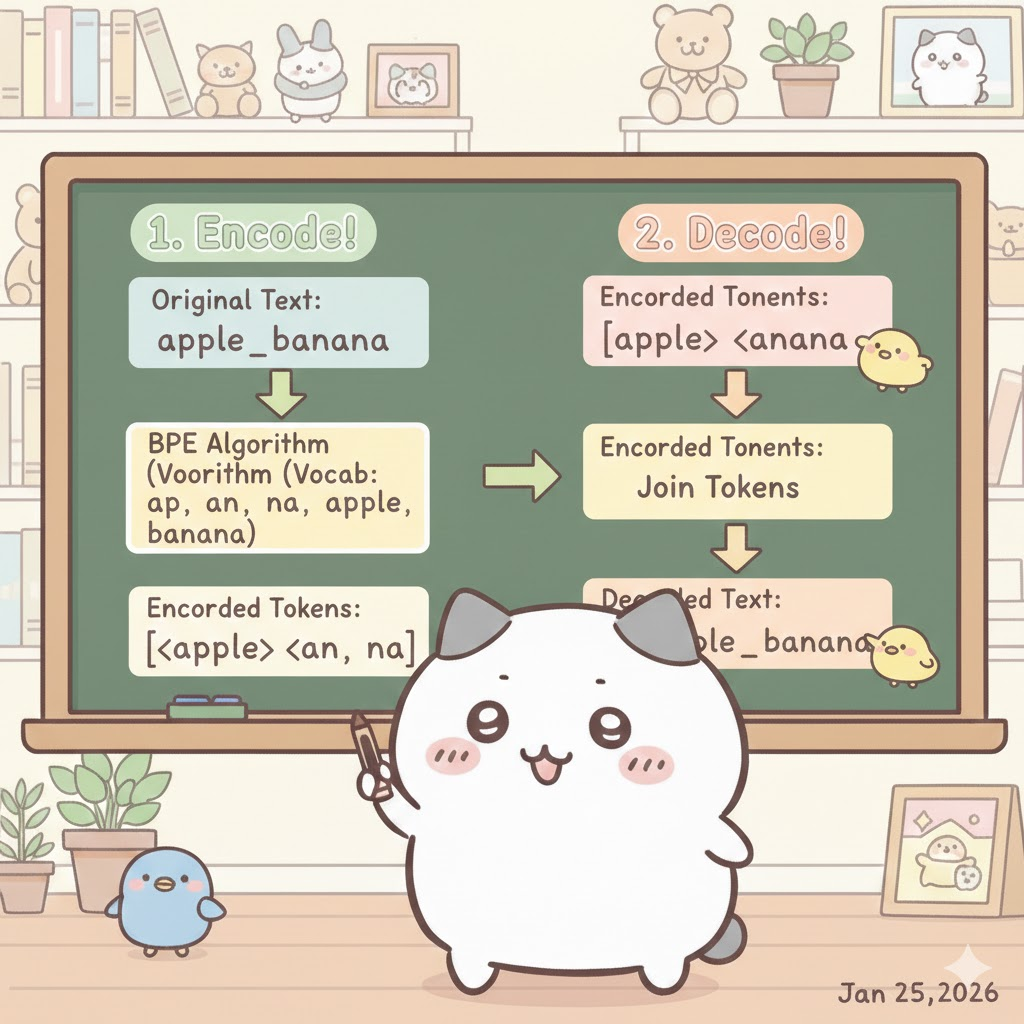